# Import

In [1]:
import networkx as nx
import pandas as pd
import goodness_indicators
import numpy as np
from algorithms.detection import detect_community_both, evaluate_f1

# Download and read graph file

In [18]:
import os
import requests
import gzip

url_list = [
    'https://snap.stanford.edu/data/bigdata/communities/com-dblp.ungraph.txt.gz',
    'https://snap.stanford.edu/data/bigdata/communities/com-dblp.all.cmty.txt.gz',
    'https://snap.stanford.edu/data/bigdata/communities/com-lj.ungraph.txt.gz',
    'https://snap.stanford.edu/data/bigdata/communities/com-lj.all.cmty.txt.gz',
]

def download_and_extract(url):
    filename = url.split('/')[-1]
    if os.path.exists(('dataset/'+filename)[:-3]):
        print('dataset/' + filename[:-3], 'already exists')
        return
    if not os.path.exists('dataset/'+filename):
        r = requests.get(url, allow_redirects=True)
        open('dataset/'+filename, 'wb').write(r.content)
    with gzip.open('dataset/'+filename, 'rb') as f_in:
        with open(('dataset/'+filename)[:-3], 'wb') as f_out:
            f_out.write(f_in.read())
    print('Extracted', filename)
    return ('dataset/'+filename)[:-3]

for url in url_list:
    download_and_extract(url)

Extracted com-dblp.ungraph.txt.gz
dataset/com-dblp.all.cmty.txt already exists
dataset/com-lj.ungraph.txt already exists
dataset/com-lj.all.cmty.txt already exists


In [2]:
# choices: 'dblp', 'lj'
dataset = 'dblp'

In [3]:
def partition_from_file(file):
    partition = []
    with open(file, 'r') as f:
        for line in f:
            if line[0] == '#':
                continue
            community = [int(x) for x in line.strip().split() if x != '']
            if len(community) > 2:
                partition.append(community)
    return partition

graph = nx.read_edgelist('dataset/com-' + dataset + '.ungraph.txt', create_using=nx.Graph(), nodetype=int)
communities = partition_from_file('dataset/com-' + dataset + '.all.cmty.txt')
print(graph.size(), len(communities))

1049866 13477


# Calculate scores for all communities
Takes 10 minutes for DBLP and around 4 hours on LiveJournal.
LiveJournal also requires 60GB of RAM (can use pagefile).

In [ ]:
# import pquality
# pquality.pquality_summary(graph, communities, 'indicators_results/' + dataset + '.csv')

  0%|          | 0/132 [01:29<?, ?it/s]


MemoryError: Error at src/core/vector.c:146: Cannot initialize vector. -- Out of memory

In [4]:
df = pd.read_csv('indicators_results/' + dataset + '.csv')
df.describe()

,FOMD,TPR,Cut Ratio,Conductance,Flake-ODF,Separability,Density,Cohesiveness,Clustering Coefficient
count,13477.000000,13477.000000,1.347700e+04,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000
mean,0.248684,0.885118,3.477260e-05,0.622430,0.455140,0.750377,0.515717,0.338212,0.753493
std,0.168397,0.168368,3.074030e-05,0.231592,0.265574,2.439646,0.301172,0.237233,0.203344
min,0.000000,0.000000,1.370000e-07,0.004739,0.000000,0.010130,0.000635,0.000864,0.000000
25%,0.125000,0.832381,1.170000e-05,0.478261,0.250000,0.120000,0.308333,0.142857,0.619048
50%,0.250000,1.000000,2.680000e-05,0.684211,0.466667,0.230769,0.476190,0.333333,0.788536
75%,0.400000,1.000000,4.910000e-05,0.806452,0.666667,0.545455,0.733333,0.571429,0.900000
max,0.500000,1.000000,4.541600e-04,0.980142,1.000000,105.000000,1.000000,1.000000,1.000000


# Analyze goodness scores

[[1], [1], [1], [1]]

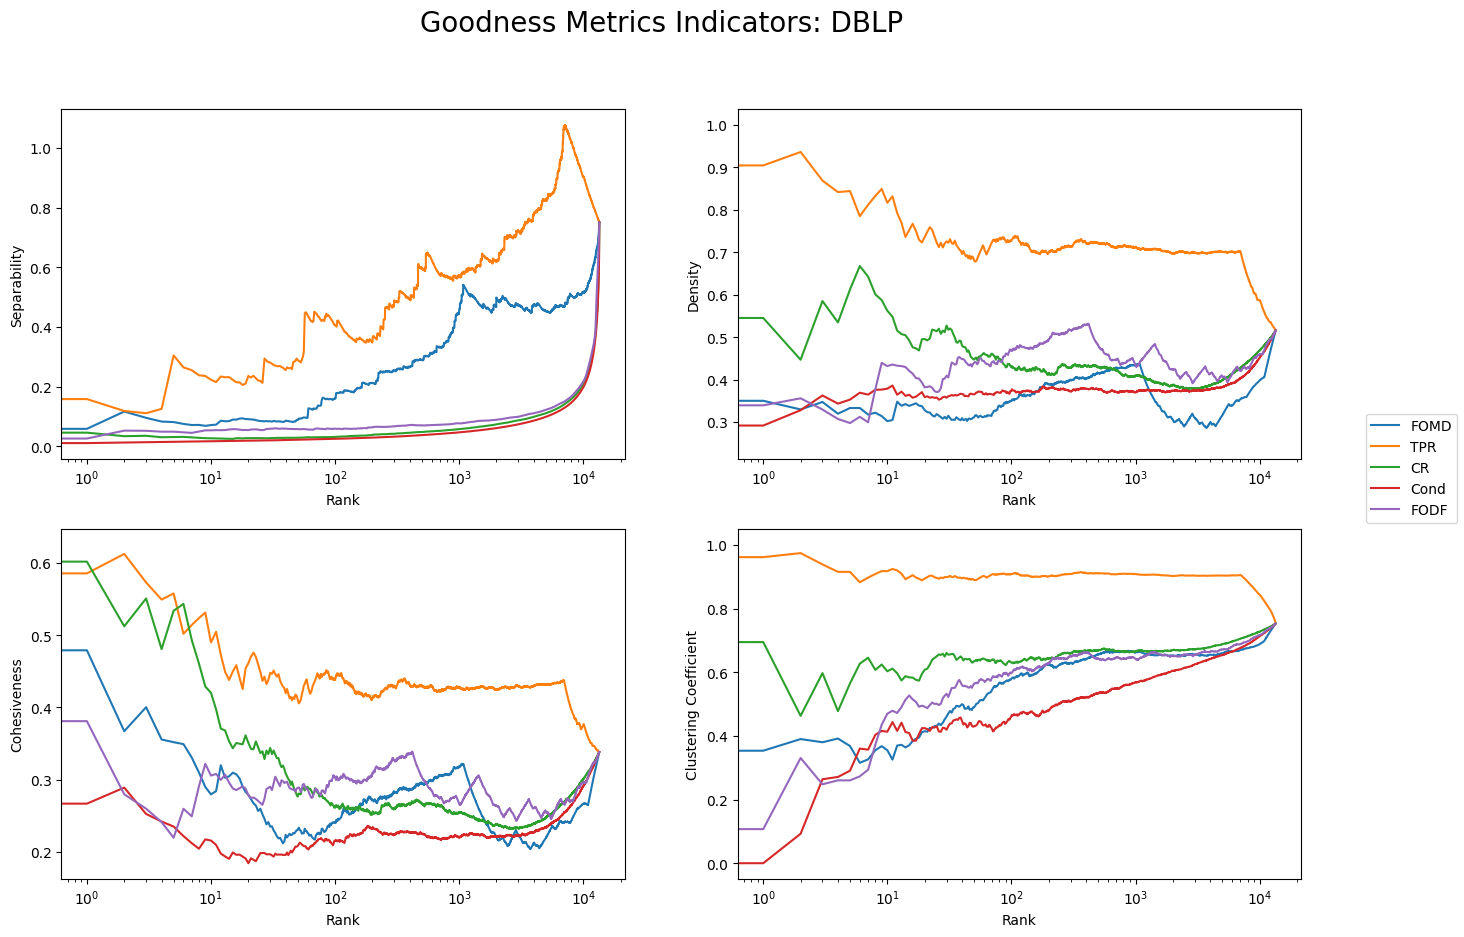

In [5]:
goodness_indicators.analyze_metric_file('indicators_results/' + dataset + '.csv', 'indicators_results')

# Detect communities from seed node

In [4]:
alpha = 1.2
beta = 0.9
epsilon = 0.001

In [7]:
community = communities[np.random.randint(0, len(communities))]
seed = np.random.choice(community)
seed

153220

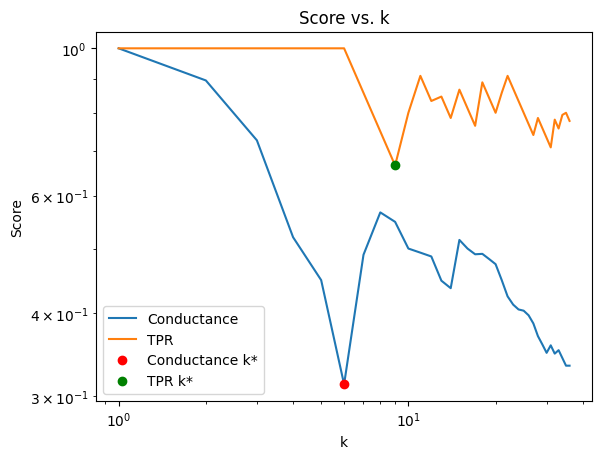

In [8]:
founded = detect_community_both(graph, seed, beta, epsilon, alpha)

In [9]:
if len(founded[0]) > 0:
    print('Community found by Conductance:')
    for i in founded[0]:
        print(i.nodes())
        print(evaluate_f1(community, i))
if len(founded[1]) > 0:
    print('Community found by TPR: ')
    for i in founded[1]:
        print(i.nodes())
        print(evaluate_f1(community, i))

Community found by Conductance:
[153220, 136167, 80103, 193673, 153331, 190618]
1.0
Community found by TPR: 
[153220, 136167, 80103, 193673, 382349, 153331, 99667, 190618, 31515]
0.8


# Calculate F1 Score

In [5]:
from tqdm import tqdm
# Calculate F1 Score
f1_conductance = []
f1_tpr = []
for community in tqdm(communities):
    seed = np.random.choice(community)
    founded = detect_community_both(graph, seed, beta, epsilon, alpha, plot=False)
    if len(founded[0]) > 0:
        f1_conductance.append(max([evaluate_f1(community, i) for i in founded[0]]))
    else:
        f1_conductance.append(0)
    if len(founded[1]) > 0:
        f1_tpr.append(max([evaluate_f1(community, i) for i in founded[1]]))
    else:
        f1_tpr.append(0)
        
print('F1 Conductance:', np.mean(f1_conductance))
print('F1 TPR:', np.mean(f1_tpr))

  0%|          | 0/13477 [00:00<?, ?it/s]

100%|██████████| 13477/13477 [1:35:47<00:00,  2.34it/s]

F1 Conductance: 0.29956202997497355
F1 TPR: 0.0668174106184639
